In [1]:
import datetime
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import heapq
from tqdm import tqdm
from itertools import groupby
tqdm.pandas()
import matplotlib.pyplot as plt
from dipy.segment.metric import ResampleFeature
from dipy.segment.metric import Metric
from dipy.segment.clustering import QuickBundles
import geopy.distance
import matplotlib.pyplot as plt
from math import *
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.preprocessing import LabelEncoder
import folium
import datetime
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 函数工具

In [2]:
# utils
def convert_gap_to_timestamp(x, y):
    days = y//24
    seconds = y%24 * 3600
    gap = datetime.timedelta(days = days, seconds = seconds)
#     result = pd.to_datetime(x, format='%Y/%m/%d  %H:%M:%S') + gap
    result = pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S') + gap
    result = str(result.year)+'/' + str(result.month) + '/' + str(result.day) + ' ' + str(result.hour) + ':' + str(result.minute) + ':' + str(result.second)
    return result
# 返回小时为单位的时间间隔
def days_hours_minutes(td):
    return round(td.days*24 + td.seconds/3600, 4)

# 将经纬度小于阈值的港口聚类
# 用于港口去重
def nearTopK(longitude, latitude, K):
#     longitude = port_info[port_info['geo_hash'] == x]['LONGITUDE'].values[0]
#     latitude = port_info[port_info['geo_hash'] == x]['LATITUDE'].values[0]
    long = abs(port_info['LONGITUDE'].values - longitude)
    lati = abs(port_info['LATITUDE'].values - latitude)
    
#     mat = list(abs(port_info['LONGITUDE'].values - longitude) + abs(port_info['LATITUDE'].values - latitude))
    mat = [x + y if x <=1 and y <=1 else 1000 for x,y in zip(long,lati)]
    temp = [x for x in list(map(mat.index, heapq.nsmallest(K + 1, mat))) if x > 0]
    print(temp)
    if temp != []:
        # 排除自身
        return port_info['TRANS_NODE_NAME'][temp[1:K+1]].values
    else:
        return None
    
# 判断到港
def nearPort(longitude, latitude):
    long = abs(port_info['LONGITUDE'].values - longitude)
    lati = abs(port_info['LATITUDE'].values - latitude)
    mat = [x + y if x <=0.25 and y <=0.25 else 1000 for x,y in zip(long,lati)]
    temp = [x for x in list(map(mat.index, heapq.nsmallest(1, mat))) if x > 0]
    if temp != []:
        return port_info['TRANS_NODE_NAME'][temp].values[0]
    else:
        return None

    # 判断端点
def nearPort2(longitude, latitude):
    long = abs(port_info['LONGITUDE'].values - longitude)
    lati = abs(port_info['LATITUDE'].values - latitude)
    mat = [x + y if x <=0.25 and y <=0.25 else 1000 for x,y in zip(long,lati)]
    temp = [x for x in list(map(mat.index, heapq.nsmallest(1, mat))) if x > 0]
    if temp != []:
        return port_info['TRANS_NODE_NAME'][temp].values[0]
    else:
        mat = [x + y if np.sqrt(x + y) <= 0.7 else 1000 for x,y in zip(long,lati)]
        temp = [x for x in list(map(mat.index, heapq.nsmallest(1, mat))) if x > 0]
        if temp != []:
            return port_info['TRANS_NODE_NAME'][temp].values[0]
        else:
            return None
        
class GPSDistance(Metric):
    def __init__(self):
        super(GPSDistance, self).__init__(feature=ResampleFeature(nb_points=256))
    
    def are_compatible(self, shape1, shape2):
        return len(shape1) == len(shape2)
    
    def dist(self, v1, v2):
        x = [geopy.distance.geodesic([p[0][0], p[0][1]], [p[1][0], p[1][1]]).km for p in list(zip(v1, v2))]
        currD = np.mean(x)
        return currD
    
def is_drop(x):
    result = []
    drop_list = []
    for i in x:
        if i not in drop_list:
            drop_list.append(i)
        if len(drop_list) >= 2:
            if i in drop_list[0:-1]:
                result.append(True)
            else:
                result.append(False)
        else:
            result.append(False)
    return result

def drop_change(data):
# 生成以及判断是否换船，换船次数，看情况使用
    tmp = data.groupby('loadingOrder')['vesselMMSI'].agg({'change': pd.Series.nunique})
    data = pd.merge(data, tmp, on=['loadingOrder'], how='left',copy=False)
    tmp = data.groupby(['loadingOrder'])['vesselMMSI'].agg({'is_drop':is_drop}).reset_index()
    b = []
    a = tmp.is_drop.values
    for i in a:
        b.extend(i)
    data['is_drop'] = b
    data = data[data['is_drop'] == False].reset_index(drop=True)
    data.drop(['is_drop'], axis=1, inplace=True)
    return data

def list_notnull(x):
    return [i for i in x if i != None]

def start_time(x):
    start = x[x['start_anchor'] == 1]['timestamp'].values[-1]
    return start

def end_time(x):
    end = x[x['end_anchor'] == 1]['timestamp'].values[0]
    return end

def last_port(x):
    port_list = []
    result = []
    for i in x:
        if str(i) == 'nan':
            result.append(port_list[-1])
        else:
            result.append(None)
            if i not in port_list:
                port_list.append(i)
    return result
    
def next_port(x):
    port_list = []
    result = []
    for i in x[::-1]:
        if str(i) == 'nan':
            result.append(port_list[-1])
        else:
            result.append(None)
            if i not in port_list:
                port_list.append(i)
    return result[::-1]
    
def last_and_next_port(data):
    tmp_last = data.groupby(['loadingOrder'])['near_port'].agg({'last_port':last_port}).reset_index()
    tmp_next = data.groupby(['loadingOrder'])['near_port'].agg({'next_port':next_port}).reset_index()
    last_ = []
    next_ = []
    a1 = tmp_last.last_port.values
    a2 = tmp_next.next_port.values
    for i,j in zip(a1,a2):
        last_.extend(i)
        next_.extend(j)
    data['new_trace'] = list(map(lambda x,y: None if x == y else x+'-'+y, last_,next_))
    return data

def after_anchor_time(data,last_trace):
    data['time_gap_diff'] = data.groupby('loadingOrder')['time_gap'].diff().fillna(0)
    tmp = data[data['new_trace'] == last_trace].groupby('loadingOrder')['timestamp'].agg({'last_timestamp':'last'})
    data = data.merge(tmp, on=['loadingOrder'], how='left', copy = False)
    tmp = data[(data['timestamp'] > data['last_timestamp']) & (~data['near_port'].isnull())].groupby('loadingOrder')['time_gap_diff'].agg({'after_anchor_time':'sum'})
    data = data.merge(tmp, on=['loadingOrder'], how='left', copy = False)
    data.drop(['time_gap_diff','last_timestamp'], axis=1, inplace=True)
    return data

class GPSDistance(Metric):
    def __init__(self):
        super(GPSDistance, self).__init__(feature=ResampleFeature(nb_points=256))
    
    def are_compatible(self, shape1, shape2):
        return len(shape1) == len(shape2)
    
    def dist(self, v1, v2):
        x = [geopy.distance.geodesic([p[0][0], p[0][1]], [p[1][0], p[1][1]]).km for p in list(zip(v1, v2))]
        currD = np.mean(x)
        return currD

def convert_gap_to_timestamp(x, y):
    days = y//24
    seconds = y%24 * 3600
    gap = datetime.timedelta(days = days, seconds = seconds)
    result = pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S.000Z') + gap
    result = str(result.year) + '/' + str(result.month) + '/' + str(result.day) + ' ' + str(result.hour) + ':' + str(result.minute) + ':' + str(result.second)
    return result

# 原始GPS数据处理

In [ ]:
#原始GPS数据抽样
df_gps = pd.read_csv("./data_row/train0711.csv")
df_gps.drop_duplicates(inplace=True)
df_gps.sort_values(['loadingOrder', 'timestamp'], inplace=True)

# gps数据采样处理
print(len(df_gps))
df_gps['timestamp'] = pd.to_datetime(df_gps['timestamp'], format="%Y-%m-%dT%H:%M:%S.000Z")
tmp = df_gps.groupby(['loadingOrder'])['timestamp'].agg({'arrive_time':'last', 'start_time':'first'})
df_gps = df_gps.merge(tmp, on='loadingOrder', how='left', copy=False)

# 数据转换
df_gps[['longitude','latitude']] = df_gps[['longitude','latitude']].astype(float)
df_gps['speed'] = df_gps['speed'].astype(int)
df_gps['direction'] = df_gps['direction'].astype(int)
df_gps = df_gps[(df_gps['speed']>=0) & (df_gps['speed']<=60) & (df_gps['direction']>=0) & (df_gps['direction']<=3600)]

# 每5分钟采样一次
df_gps['time_gap'] = df_gps['timestamp'] - df_gps['start_time']
df_gps['time_gap'] = df_gps['time_gap'].map(lambda x: days_hours_minutes(x))
df_gps['resample'] = df_gps['time_gap'] // 0.083
df_gps = df_gps.groupby(['loadingOrder', 'resample']).head(1).reset_index(drop=True)

print(len(df_gps))

In [ ]:
# 处理换船订单
df_gps = drop_change(df_gps)

## 港口清洗

In [ ]:
# 获得出现在训练集中的港口
order_transport = df_gps[df_gps['TRANSPORT_TRACE'].notnull()][['loadingOrder','TRANSPORT_TRACE']].drop_duplicates(subset=['loadingOrder','TRANSPORT_TRACE']).reset_index(drop=True)
order_transport.to_csv("./复赛data/order_transport.csv", index = None)
order_transport = pd.read_csv("./data_row/order_transport.csv")
port_list = []
for i in order_transport['TRANSPORT_TRACE']:
    port = i.split("-")
    port_list += port
port_list = list(set(port_list))

In [3]:
# port表经纬度微调
df_port = pd.read_csv("./data_row/port.csv")
port_info = df_port[['TRANS_NODE_NAME','LONGITUDE','LATITUDE','COUNTRY','STATE','CITY']]
# port_info.loc[port_info['TRANS_NODE_NAME'] == 'BANGUI_CENTRAL AFRICAN REPUBLIC', 'TRANS_NODE_NAME'] = 'BANGUI'
port_info.loc[port_info['TRANS_NODE_NAME'] == 'CRLIO','LONGITUDE'] = -83.045998
port_info.loc[port_info['TRANS_NODE_NAME'] == 'CRLIO','LATITUDE'] = 9.992181
# 非正常港口
port_info = port_info[(abs(port_info['LONGITUDE'] + 0.386592) >= 1e-5) & (abs(port_info['LATITUDE'] -  0.831116) >= 1e-5)]
port_info = port_info[(abs(port_info['LATITUDE'] + 0.386592) >= 1e-5) & (abs(port_info['LONGITUDE'] -  0.831116) >= 1e-5)]
port_info = port_info[port_info['TRANS_NODE_NAME'] != 'VAN']
port_info = port_info[port_info.TRANS_NODE_NAME.isin(port_list)].reset_index(drop=True)
port_info.index = port_info.index + 1
port_info.loc[0] = ['not__',106.54,29.59,None,None,None]
port_info.sort_index(inplace=True)
 
# 添加修正港口数据
port_info = port_info.append(pd.DataFrame({
    'TRANS_NODE_NAME':'NLRTM',
    'LONGITUDE':4.001,
    'LATITUDE':51.96
},index=[0]), ignore_index=True)
port_info = port_info.append(pd.DataFrame({
    'TRANS_NODE_NAME':'CNSHA',
    'LONGITUDE':122.0341,
    'LATITUDE':30.6308
},index=[0]), ignore_index=True)
port_info = port_info.append(pd.DataFrame({
    'TRANS_NODE_NAME':'CAVAN',
    'LONGITUDE':-123.1491,
    'LATITUDE':49.0203
},index=[0]), ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


NameError: name 'port_list' is not defined

In [3]:
# 过滤重名现象
# 可用前面定义的nearTopK函数进行判断
port_kinds = []
port_kinds.append(['MYPKG','MYLPK','MYLPK','MYWSP','537165','0S'])
port_kinds.append(['DGBJ1','HTM.????1'])
port_kinds.append(['ARENA','ARBUE'])
port_kinds.append(['CRLIO','CRPLI'])
port_kinds.append(['AUMEL','MELBOURNE'])
port_kinds.append(['BHBAH','BHKBS'])
port_kinds.append(['LBBEY','BEY'])
port_kinds.append(['CVRAI','CVPRA'])
port_kinds.append(['BNMUH','BNMUA'])
port_kinds.append(['CLIQQ','ARRAZ'])
port_kinds.append(['CLSAN','CLSAI'])
# CNSHK | CNNSA很近 | HON很近
port_kinds.append(['CNSHK','CNDCB','CNCWN','SZX','SHEKOU'])
# CNYTN | HON很近
port_kinds.append(['CNYTN','YTN','YANTIAN'])
# CNSHA| CNSGH上海 ！！！
port_kinds.append(['CNSHA','CNSGH','SHA'])
port_kinds.append(['CNXMN','CNXAM'])
port_kinds.append(['CIABJ','ABIDJAN'])
port_kinds.append(['HRRIJ','RJK','HRRJK','HUNGARY'])
port_kinds.append(['EGEDK','EGALY'])
port_kinds.append(['DOCAU','DOSDQ','DOHAI'])
port_kinds.append(['EGPSD','EGPSE','EGPSA'])
port_kinds.append(['DEHAM','HAM'])
port_kinds.append(['GRPIR','PIRAEUS_GREECE','PIRAEUS_GREECE','PIRAEUS_GREECE','PIR'])
# HON | CNSHK很近
port_kinds.append(['CNHKG','HKG','HONGKONG','HKHKG','HON'])
port_kinds.append(['INNSA','INBOM'])
port_kinds.append(['JPTYO','TOKYO'])
port_kinds.append(['JPHKT','JPFUK'])
port_kinds.append(['JOAQJ','AQABA'])
port_kinds.append(['KEMBA','KEMOM'])
port_kinds.append(['MTMLA','MTMAR','MALTA'])
port_kinds.append(['MRNKC','MRNOU'])
port_kinds.append(['NLRTM','ROTTERDAM_CCPlace','RTM','NLROT'])
port_kinds.append(['NZAKL','AKL'])
port_kinds.append(['NGAPP','NGTIN'])
port_kinds.append(['PKKHI','PKKCT','PKPCT'])
# PAONX
port_kinds.append(['PAONX','COLON FREE TRADE ZONE','MANZANILLO_PANAMA', 'PACOL','PACFZ','COLON CONTAINER TERMINAL','PAMAN'])
port_kinds.append(['PABLB','PABAL','PAPAN','PAMIT'])
port_kinds.append(['PYASU','ASUNCION'])
port_kinds.append(['PHBTG','PHBAT'])
port_kinds.append(['PHMNL','PHMNN','PHMAN','PHMNS'])
port_kinds.append(['PHDVO','PHDAV'])
port_kinds.append(['ROCND','ROCON'])
port_kinds.append(['RUNOV','RUNVS'])
port_kinds.append(['REREU','REPDG','RELPT'])
port_kinds.append(['SCVIC','SCPOV'])
port_kinds.append(['SADMM','SADAM','DAMMAM'])
port_kinds.append(['SNDKR','KATI'])
port_kinds.append(['SLFNA','SLFRE'])
# SIKOP 和 'ITTRS' 及其近，几乎可以视作同一个
port_kinds.append(['SIKOP','KOP'])
port_kinds.append(['SOBER','SOBBO'])
port_kinds.append(['KRINC','KRICH'])
port_kinds.append(['TGLFW','TGFLW'])
# 下面两个同一国家，较近
port_kinds.append(['UAILK','UAODS'])
port_kinds.append(['UAILK','UAYUZ'])
port_kinds.append(['VNHPG','VNHPH'])
port_kinds.append(['VNVUT','VNSGN'])
port_kinds.append(['VNDAD','VNDAN'])
port_kinds.append(['CIABJ','FALADIE'])
port_kinds.append(['OMSLL','OMSAL'])
port_kinds.append(['FRMRS','FOS'])
port_kinds.append(['CNTAO','CNQIN'])
port_kinds.append(['TRMER','ZAKHO_IRAQ'])
port_kinds.append(['IDJKT','IDJAK','JAKARTA'])
port_kinds.append(['YTLON','LONGONI'])
port_kinds.append(['THLKB','THBKK'])
port_kinds.append(['TRYAR','TRKOR'])
port_kinds.append(['MEBAR','BAR'])
port_kinds.append(['EGSUE','EGSUZ'])
port_kinds.append(['PKBQM','PKQCT'])
port_kinds.append(['CMKBI','CRKBI'])
port_kinds.append(['TRCAN','TRCKZ'])
port_kinds.append(['ESVAL','ESVLC'])
port_kinds.append(['GTIZ4','HNTGU'])
# SINGAPORE_SINGAPORE有问题去掉
# port_kinds.append([])
# 'MYTPP'和'SGSIN'很近、 MYPGU和SGSIN很近
# 'ITTRS'和SIKOP很近
port_info = port_info[port_info['TRANS_NODE_NAME'] != 'MYPGU'].reset_index(drop=True)
# 替换路由部分
for i in port_kinds:
    port_info['TRANS_NODE_NAME'] = port_info['TRANS_NODE_NAME'].map(lambda x: i[0] if x in i else x)
    
port_info.to_csv("./data_row/port_new.csv", index=None)

NameError: name 'port_info' is not defined

# 训练数据和测试数据处理

In [ ]:
port_info = pd.read_csv("./data_row/port_new.csv")

# 获取真实路由
df_gps['near_port'] = df_gps.progress_apply(lambda row: nearPort(row['longitude'],row['latitude']) if row['speed'] < 10 else 
                                   nearPort(row['longitude'],row['latitude']) if (row['timestamp'] == row['start_time'] or row['timestamp'] == row['arrive_time'])
                                   else None, axis=1)

tmp = df_gps.groupby('loadingOrder')['near_port'].agg({'new_transport_trace':list_notnull})
tmp['new_transport_trace'] = list(map(lambda x: "-".join([ x for x in [i[0] for i in groupby([i for i in x if i != None])]]),tmp['new_transport_trace']))
df_gps = pd.merge(df_gps, tmp, on='loadingOrder', how='left', copy=False)
df_gps.to_csv("./data_row/df_gps.csv",index=None)
all_order_transport = df_gps[['loadingOrder','new_transport_trace']].drop_duplicates(subset=['loadingOrder','new_transport_trace']).reset_index(drop=True)
all_order_transport.to_csv("./data_row/all_order_transport.csv", index=None)

# 读取数据进行处理

In [4]:
# 读取之前生成的文件
df_gps = pd.read_csv("./data_row/df_gps.csv")
port_info = pd.read_csv("./data_row/port_new.csv")

In [5]:
# 测试集采样处理
df_test = pd.read_csv("./data_row/Btest0711_ALL.csv")
# testData 0626
df_test['timestamp'] = df_test['timestamp'].map(lambda x: pd.to_datetime(x, format="%Y-%m-%dT%H:%M:%S.000Z"))
df_test['onboardDate'] = df_test['onboardDate'].map(lambda x: pd.to_datetime(x, format="%Y/%m/%d  %H:%M:%S"))
print(len(df_test))

# 数据转换去噪
df_test[['longitude','latitude']] = df_test[['longitude','latitude']].astype(float)
df_test['speed'] = df_test['speed'].astype(int)
df_test['direction'] = df_test['direction'].fillna(-1).astype(int)
df_test['direction'] = df_test['direction'].astype(int)
df_test = df_test[(df_test['speed']>=0) & (df_test['speed']<=60) & (df_test['direction']>=0) & (df_test['direction']<=36000)]

# gps数据采样处理
tmp = df_test.groupby(['loadingOrder'])['timestamp'].agg({'arrive_time':'last', 'start_time':'first'})
df_test = df_test.merge(tmp, on='loadingOrder', how='left', copy=False)


# 每5分钟采样一次
df_test['time_gap'] = df_test['timestamp'] - df_test['start_time']
df_test['time_gap'] = df_test['time_gap'].map(lambda x: days_hours_minutes(x))
df_test['resample'] = df_test['time_gap'] // 0.083
df_test = df_test.groupby(['loadingOrder', 'resample']).head(1).reset_index(drop=True)

df_test['near_port'] = df_test.apply(lambda row: nearPort(row['longitude'],row['latitude']) if row['speed'] < 10 else None, axis=1)

df_test['start_port'] = df_test['TRANSPORT_TRACE'].map(lambda x: str(x).split("-")[0])
df_test['end_port'] = df_test['TRANSPORT_TRACE'].map(lambda x: str(x).split("-")[-1])
for i in port_kinds:
    df_test['start_port'] = df_test['start_port'].map(lambda x: i[0] if x in i else x)
    df_test['end_port'] = df_test['end_port'].map(lambda x: i[0] if x in i else x)
print(len(df_test))
df_test['start_port'] = list(map(lambda x,y: 'HRRIJ' if x == 'HUNGARY' and y == 'CNHKG' else x, df_test['start_port'],df_test['end_port']))
df_test['start_port'] = list(map(lambda x,y: 'CNYTN' if x == 'CNSHK' and y == 'ESVAL' else x, df_test['start_port'],df_test['end_port']))
# 处理换船订单
df_test = drop_change(df_test)

57071
23998


# 清洗源路由以及保存路由文件，方便后面调用

In [6]:
for port_kind in port_kinds:
    df_test['TRANSPORT_TRACE'] = df_test['TRANSPORT_TRACE'].map(lambda x: "-".join([port_kind[0] if i in port_kind else i for i in str(x).split("-")]))

In [7]:
test_order_transport = df_test[['loadingOrder','start_port','end_port','vesselMMSI','TRANSPORT_TRACE']].drop_duplicates()
train_order_transport = pd.read_csv("./data_row/all_order_transport.csv")
train_order_transport['new_transport_trace'] = train_order_transport['new_transport_trace'].fillna('0')

In [8]:
train_order_transport = train_order_transport.merge(df_gps[['loadingOrder','vesselMMSI']].drop_duplicates(), on='loadingOrder',
                                                   how='left',copy=False)

In [9]:
train_order_transport['new_transport_trace'] = train_order_transport['new_transport_trace'].map(lambda x: "-".join([i for i in str(x).split("-") if i != 'MYPGU']))

In [10]:
df_gps['near_port'] = df_gps['near_port'].map(lambda x: 'nan' if x == 'MYPGU' else x) # 处理掉异常港口(现有到港规则容易误判)

# 模型预测部分

In [13]:
# 计算球面距离
def geodistance(lng1,lat1,lng2,lat2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    dis=2*asin(sqrt(a))*6371*1000
    return dis

# 计算两点曼哈顿距离
def manhattanDistance(lng1,lat1,lng2,lat2):
    return abs(lng1 - lng2) + abs(lat1 - lat2)

# LGB回归模型基础特征生成
def get_data_feature(data, test_data):
    label_carrierName = LabelEncoder().fit(pd.concat([data['carrierName'], test_data['carrierName']], axis=0))
    label_vesselMMSI = LabelEncoder().fit(pd.concat([data['vesselMMSI'], test_data['vesselMMSI']], axis=0))
    def get_feature(df, dtype='train'):
        df['carrierName'] = label_carrierName.transform(df['carrierName'])
        df['vesselMMSI'] = label_vesselMMSI.transform(df['vesselMMSI'])
        
        # 速度
        tmp = pd.DataFrame(df.groupby(['loadingOrder'])['speed'].agg({'mean_speed':'median'}))
        df = df.merge(tmp, on='loadingOrder', how='left', copy=False)
        
        # 方向
        tmp = pd.DataFrame(df.groupby(['loadingOrder'])['direction'].agg({'mean_direction':'mean'}))
        df = df.merge(tmp, on='loadingOrder', how='left', copy=False)
        
        # 时间
        df['month'] = df['timestamp'].map(lambda x:x.month)
        df['year'] = df['timestamp'].map(lambda x:x.year)
        df['day'] = df['timestamp'].map(lambda x:x.day)
        
#         next_port = df['new_trace'].values[0].split("-")[-1]
        next_port = df['end_port'].values[-1]
        df['end_longitude'] = port_info[port_info['TRANS_NODE_NAME'] == next_port]['LONGITUDE'].values[0]
        df['end_latitude'] = port_info[port_info['TRANS_NODE_NAME'] == next_port]['LATITUDE'].values[0]
        
        df['distance_will'] = list(map(lambda x,y,z,q: geodistance(x,y,z,q),
                                df['longitude'],df['latitude'],df['end_longitude'],df['end_latitude']))
        df['mhdistance_will'] = list(map(lambda x,y,z,q: manhattanDistance(x,y,z,q),
                                df['longitude'],df['latitude'],df['end_longitude'],df['end_latitude']))
        feature = ['carrierName','vesselMMSI','speed','direction','longitude','latitude','day',

                    'month', 'year','distance_will']
        if dtype == 'test':
            return df
        else:
            return df, df['label'], feature
    train_feat, label, feature = get_feature(data)
    test_feat = get_feature(test_data,'test')
    return train_feat, test_feat, label, feature

# 获取当前后面停止时间
def get_anchor_time(data, test_data):
    onboardDate = test_data['onboardDate'].map(lambda x:str(x.year) + '-'+ str(x.month) + '-' + str(x.day)).values[0]
    start_anchor_time = data[['start_time','after_anchor_time']].drop_duplicates().reset_index(drop=True)
    start_anchor_time['start_time_2'] = start_anchor_time['start_time'].map(lambda x:str(x.year) + '-'+ str(x.month) + '-' + str(x.day))
    if onboardDate in start_anchor_time['start_time_2'].values.tolist():
        anchor_time = start_anchor_time[start_anchor_time['start_time_2'] == onboardDate]['after_anchor_time'].values[0]
    else:
        anchor_time_list = list(set(data['after_anchor_time']))
        if len(anchor_time_list) <= 2:
            anchor_time = np.min(anchor_time_list)
        else:
            anchor_time = np.median(anchor_time_list)
    return anchor_time
            

def get_LGB_pred(train, test, label, feature, if_valid):
    # 是否进行5折验证
    if if_valid:
        df_order = list(set(train['loadingOrder']))
        train_order, test_order,train_index, test_index = train_test_split(df_order,range(0,len(df_order)),test_size=0.1,random_state=2020)
        x_train, x_valid = train[train['loadingOrder'].isin(train_order)][feature], train[train['loadingOrder'].isin(test_order)][feature]
        y_train, y_valid = label[train['loadingOrder'].isin(train_order)], label[train['loadingOrder'].isin(test_order)]
        
        model_lgb = lgb.LGBMRegressor(num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='mse',max_depth=-1,learning_rate=0.01,
                             min_child_samples=10, random_state=2020, n_estimators=1000, subsample=0.9, colsample_bytree=0.7)

        watchlist=[(x_train, y_train), (x_valid, y_valid)]
        model_lgb.fit(x_train, y_train,
                     eval_set=watchlist, verbose=100, eval_metric='mse')
        y_hat = model_lgb.predict(x_valid)
        
        print(MSE(y_hat, y_valid))
        print(pd.DataFrame({
            'column':feature,
            'importance':model_lgb.feature_importances_,
        }).sort_values(by='importance'))
    #全量数据
    model_lgb = lgb.LGBMRegressor(num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='mse',max_depth=-1,learning_rate=0.05,
                                 min_child_samples=10, random_state=2020, n_estimators=1000, subsample=0.9, colsample_bytree=0.7)
    model_lgb.fit(train[feature], label, verbose=0)
    return model_lgb.predict(test[feature])

In [14]:
df_gps.drop(['start_time','arrive_time'], axis=1, inplace=True)
df_gps['timestamp'] = pd.to_datetime(df_gps['timestamp'], format="%Y-%m-%d %H:%M:%S")
df_test['label'] = 0
# 结果记录
results = df_test[['loadingOrder','label']].drop_duplicates().reset_index(drop=True)

1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>----------------------------------------------------------------------------
YV342585220795
CNYTN MXZLO
['LT317630841182', 'BJ178385017060', 'DC366669784535', 'CL370368914639', 'UB146439786225', 'CP121567293891', 'AZ276880454886', 'FH222000717161', 'AH861147242321', 'KJ553632286209', 'BN148310107570', 'DR466932338116', 'BF895336529876', 'GL112509210356', 'ET658842069157', 'EM639816929631', 'SR359134753724', 'CL497017499228', 'LU500667407037', 'BL905454125775', 'HN243647397835', 'BD203889869580', 'AZ165684400071', 'EU719039426186', 'MG337534416779', 'FZ764975349780', 'AA191175561416', 'HX297154217702', 'AL979269865349', 'MH505071761258', 'CC882170548734', 'SR206397544670', 'BG418658747879', 'DE635882399779', 'EG806694905580', 'DK560311623680', 'CN382336655675', 'JQ201608451909', 'TV611475139919', 'PN873754278438', 'CC440953430042', 'CU927993917563', 'LR496246472700', 'JB328944608711', 'LQ137479719704', 'YC743781609721', 'AO287854813767', 'ES312530159936', 

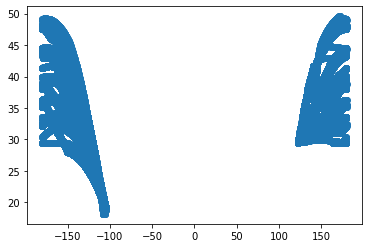

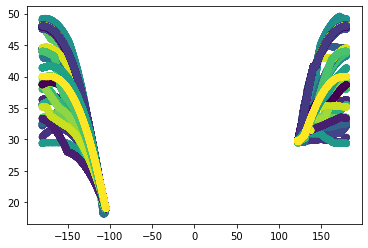

[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 1.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
6.0
同段订单数：7
靠港口时间：% [0.09699999999997999, 0.08910000000003038, 0.102800000000002, 0.0969000000000051, 0.3974999999999227, 5.589999999999918, 0.06410000000005311]
靠港口时间：%         after_anchor_time          start_time    loadingOrder   vesselMMSI  \
30306           

In [15]:
# 注意CNSHK到SGSIN的聚类会比较慢（本模型只跑了该路由占比较大的订单），在真实场景中应该对其先进行聚类以便复用，这样也能做到实时预测，否则比较慢
# 模型核心思路是
# 1. 取测试集正常行驶的数据
# 2. LGB和KNN预测当前航行到整条航段的哪一个阶段（如A-B-C, 得到现在处于B-C阶段），那么我们就抽取B-C的数据作为训练集
# 3. 得到某阶段数据后，用quickbundles聚类得到最相似的部分路径作为历史轨迹进行学习
# 4. LGB模型进行学习，得到最后的预测结果

not_CNSHK_sg_my_order = list(map(lambda x,y,z:None if (('CNSHK' == y) and (('MYTPP' == z) or ('SGSIN' == z))) else x,test_order_transport['loadingOrder'],test_order_transport['start_port'],test_order_transport['end_port']))
not_CNSHK_sg_my_order = list(filter(None, not_CNSHK_sg_my_order))
# CNSHK到SGSIN的聚类会比较慢（本模型只跑了占比较大的订单）,其他的直接采用队友融合结果
not_CNSHK_sg_my_order.append('GW839821198326')
not_CNSHK_sg_my_order.append('OI667693935289')
flag=0
order_num = 1

# 极少量订单（如下）由于训练数据少，极易预测航段出现偏差，预测与队友模型会出现较大偏差（实际情况对于冷启动问题可用整体预测进行修正,
#另外我们在分类航段的时候加入了test本身为未知航段unknown标签，以减少冷启动带来的误差），会对预测航段方式进行统一参数调整
sorder1 = ['TT576403892275','OF386162750817','QO176063403469','RY419216415067','UU854609945095','LP806348910035','ZP821701807400',
           'ZX687996032865','JU877708983002','OI667693935289','UU855384397170','WG447072368140']
sorder2 = ['FX975491217543']
not_test_order_transport = test_order_transport[test_order_transport['loadingOrder'].isin(not_CNSHK_sg_my_order)]
for order, trace_start,trace_end, vessel, transport_trace in zip(not_test_order_transport['loadingOrder'],not_test_order_transport['start_port'],not_test_order_transport['end_port'],not_test_order_transport['vesselMMSI'],not_test_order_transport['TRANSPORT_TRACE']):
    try:
        print("%d>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>----------------------------------------------------------------------------"%(order_num))
        print(order)
        print(trace_start, trace_end)
        trace_len = len(transport_trace.split("-"))
        tmp_tot = train_order_transport[(train_order_transport['new_transport_trace'].str.contains(trace_start+".+"+trace_end, regex=True))]
        train_data = df_gps[(df_gps['loadingOrder'].isin(tmp_tot['loadingOrder'].values.tolist()))]
        train_data['start_anchor'] = train_data['near_port'].map(lambda x: 1 if x == trace_start else 0)
        train_data['end_anchor'] = train_data['near_port'].map(lambda x: 1 if x == trace_end else 0)

        tmp = train_data.groupby('loadingOrder').apply(start_time).reset_index()
        tmp.columns = ['loadingOrder','start_time']
        train_data = train_data.merge(tmp, on = 'loadingOrder', how='left', copy=False)

        tmp = train_data.groupby('loadingOrder').apply(end_time).reset_index()
        tmp.columns = ['loadingOrder','arrive_time']
        train_data = train_data.merge(tmp, on = 'loadingOrder', how='left', copy=False)


        train_data = train_data[(train_data['timestamp']>=train_data['start_time']) & (train_data['timestamp']<=train_data['arrive_time'])]
        train_data['start_port'] = trace_start
        train_data['end_port'] = trace_end
        # 同订单同船去重
        train_data['label'] = train_data['arrive_time'] - train_data['start_time']
        tmp = train_data.drop_duplicates(subset=['start_port', 'end_port', 'label'])
        drop_list = tmp['loadingOrder'] + tmp['start_port'] + tmp['end_port']
        train_data['drop_list'] = train_data['loadingOrder'] + train_data['start_port'] + train_data['end_port']
        train_data = train_data[train_data['drop_list'].isin(drop_list)].reset_index(drop=True)
        label = train_data['arrive_time'] - train_data['start_time']
        label = [days_hours_minutes(x) for x in label]
        print(list(set(train_data['loadingOrder'])))
        print(list(set(label)))
        show_list = list(set(train_data['loadingOrder']))

#         用于可视化分析
#         tmp = df_gps[df_gps['loadingOrder'].isin(show_list)]
#         tmp.sort_values(['loadingOrder','timestamp'],inplace=True)
#         tmp['lat_lon'] = list(map(lambda x,y: [x,y], tmp['latitude'], tmp['longitude']))
#         tmp = tmp.groupby('loadingOrder')['lat_lon'].agg({'lat_lon_list':list}).reset_index()
#         visual = tmp['lat_lon_list'].values.tolist()
#         visual_order = tmp['loadingOrder'].values.tolist()
#         m = folium.Map(location = visual[0][0], zoom_start=4)
#         for i, od in enumerate(visual):
#             route = folium.PolyLine(
#                 visual[i],
#                 tooltip=visual_order[i],
#                 weight=1,
#                 color='red',
#                 opacity=0.5
#             ).add_to(m)   

        test_sample = df_test[(df_test['loadingOrder'] == order)]
        # 判断是否已经到港
        if trace_end in list(set(test_sample['near_port'])):
            results.loc[results['loadingOrder'] == order,'label'] = 0
            tmp = test_sample.groupby('loadingOrder')['timestamp'].agg({'last'})
            results.loc[results['loadingOrder'] == order,'timestamp'] = tmp.values[0]
            print(tmp.values[0])
        # LGB分类航段
        else:
            train_data = last_and_next_port(train_data)
            train_sample = train_data[~train_data['new_trace'].isnull()]
            test_sample = test_sample[(test_sample['speed']>0) & (test_sample['speed']<=60)  & (test_sample['direction']<=36000)& (test_sample['direction']>=0) ]
            # 去掉停止数据
            test_sample = test_sample[test_sample['near_port'].isnull()].reset_index(drop=True)
            test_sample['new_trace'] = 'unknown'
            lgb_model = lgb.LGBMClassifier(num_leaves=2**5-1, reg_lambda=0.1, objective='muticlass',max_depth=-1, 
                                     learning_rate=0.05, min_child_samples=1,random_state=2020, 
                                     n_estimators=200, subsample=0.9,colsample_bytree=0.7, num_threads=-1)

            lgb_model.fit(np.r_[train_sample[['longitude','latitude','direction']].values,test_sample[['longitude','latitude','direction']].values], np.r_[train_sample['new_trace'].values,test_sample['new_trace'].values])
            test_sample['new_trace'] = lgb_model.predict(test_sample[['longitude','latitude','direction']])
            print(test_sample['new_trace'])
            traces = test_sample['new_trace'].values.tolist()[-3:]
            last_trace = max(traces, key=traces.count)

            test_sample = test_sample[test_sample['new_trace'] == last_trace]
            if (last_trace == 'unknown') or (order in sorder1):
                k_alpha = 1 if order in sorder1 else 5
                print(k_alpha)
                Knn_model = KNeighborsClassifier(n_neighbors=k_alpha)
                test_sample['new_trace'] = 'unknown'
                Knn_model.fit(np.r_[train_sample[['longitude','latitude']].values,test_sample[['longitude','latitude']].values], np.r_[train_sample['new_trace'].values,test_sample['new_trace'].values])
                test_sample['new_trace'] = Knn_model.predict(test_sample[['longitude','latitude']])
                print(test_sample['new_trace'])
                traces = test_sample['new_trace'].values.tolist()[-3:]
                last_trace = max(traces, key=traces.count)
            if last_trace == 'unknown':
                print(last_trace)
                train_sample = train_data
                train_sample['all_gap'] = train_data['arrive_time'] - train_data['start_time']
                train_sample['all_gap'] = train_sample['all_gap'].map(lambda x:days_hours_minutes(x))
                # 去噪
                tmp = pd.DataFrame(train_sample.groupby(['start_port','end_port'])['all_gap'].agg({'median_gap':'median'}))
                train_sample = pd.merge(train_sample, tmp, on=['start_port','end_port'], how='left', copy=False)
                train_sample = train_sample[(train_sample['all_gap'] >= train_sample['median_gap']*0.8) & (train_sample['all_gap'] <= train_sample['median_gap']*1.2)]
                print(len(list(set(train_sample['loadingOrder']))))

                train_sample['label'] = train_sample['arrive_time'] - train_sample['timestamp']
                train_sample['label'] = train_sample['label'].map(lambda x: days_hours_minutes(x))
                # LGB回归预测
                train_feat,test_feat,label,feature = get_data_feature(train_sample,test_sample)
                result = get_LGB_pred(train_feat,test_feat,label, feature, if_valid = False)
                ETA_time = convert_gap_to_timestamp(test_sample['timestamp'].values[-1], result[-1])
                print(days_hours_minutes(pd.to_datetime(ETA_time, format='%Y/%m/%d %H:%M:%S') - test_sample['onboardDate'].values[-1]))
                results.loc[results['loadingOrder'] == order,'label'] = result[-1]
                results.loc[results['loadingOrder'] == order,'timestamp'] = test_sample['timestamp'].values[-1]
                
                print("靠港口时间：%",train_data[['start_time','loadingOrder','vesselMMSI','carrierName']].drop_duplicates().sort_values(['start_time']))
                print(days_hours_minutes(pd.to_datetime(ETA_time, format='%Y/%m/%d %H:%M:%S') - test_sample['onboardDate'].values[-1]))
                print(ETA_time)
#               可用于可视化
#                 tmp = df_test[df_test['loadingOrder'] == order]
#                 tmp.sort_values(['loadingOrder','timestamp'],inplace=True)
#                 tmp['lat_lon'] = list(map(lambda x,y: [x,y], tmp['latitude'], tmp['longitude']))
#                 tmp = tmp.groupby('loadingOrder')['lat_lon'].agg({'lat_lon_list':list}).reset_index()
#                 visual = tmp['lat_lon_list'].values.tolist()
#                 visual_order = tmp['loadingOrder'].values.tolist()
#                 for i, od in enumerate(visual):
#                     route = folium.PolyLine(
#                         visual[i],
#                         tooltip=visual_order[i],
#                         weight=1,
#                         color='blue',
#                         opacity=0.5
#                     ).add_to(m)

#                 m.add_child(folium.LatLngPopup())

#                 m.save("./image2/"+str(order)+str(trace_start)+'-'+str(trace_end)+".html")
            else:
                print(last_trace)
                train_data = after_anchor_time(train_data, last_trace)
                train_sample = train_data[train_data['new_trace'] == last_trace]
                print("总订单数：%d"%(len(list(set(train_sample['loadingOrder'])))))

                X = train_sample[['longitude', 'latitude']].values
                plt.scatter(X[:,0], X[:,1], marker='o')
                plt.show()

                train_sample['lat_lon'] = list(map(lambda x,y: np.array([x, y]), train_sample['latitude'], train_sample['longitude']))
                tmp = train_sample.groupby('loadingOrder')['lat_lon'].agg({'lat_lon_list':list}).reset_index()
                tmp['lat_lon_list'] = tmp['lat_lon_list'].map(lambda x: np.array(x))
                tmp_order = tmp['loadingOrder'].values

                metric = GPSDistance()
                q_threshold = 1 if order in sorder2 else 25
                qb = QuickBundles(threshold=q_threshold, metric=metric)
                clusters = qb.cluster(tmp['lat_lon_list'].values)

                for kind, i in enumerate(clusters):
                    train_sample.loc[train_sample['loadingOrder'].isin(tmp_order[i.indices]),'kind'] = kind

                kind = train_sample['kind'].values
                plt.scatter(X[:,0], X[:,1], c=kind)
                plt.show()
                
                k_alphal2 = 5 if order in sorder2 else 1
                Knn_model = KNeighborsClassifier(n_neighbors=k_alphal2)
                Knn_model.fit(train_sample[['longitude','latitude']].values, train_sample['kind'].values)

                test_sample['kind'] = Knn_model.predict(test_sample[['longitude','latitude']].values)
                kinds = test_sample['kind'].values.tolist()
                print(test_sample['kind'].values.tolist())
                last_kind = max(kinds, key=kinds.count)
                print(last_kind)
                test_sample = test_sample[test_sample['kind'] == last_kind]
                train_sample = train_sample[train_sample['kind'] == last_kind]
                print("同段订单数：%d"%(len(list(set(train_sample['loadingOrder'])))))

#               可用于数据可视化
#                 show_list = list(set(train_sample['loadingOrder']))

#                 tmp = df_gps[df_gps['loadingOrder'].isin(show_list)]
#                 tmp.sort_values(['loadingOrder','timestamp'],inplace=True)
                
#                 tmp['lat_lon'] = list(map(lambda x,y: [x,y], tmp['latitude'], tmp['longitude']))
#                 tmp = tmp.groupby('loadingOrder')['lat_lon'].agg({'lat_lon_list':list}).reset_index()
#                 visual = tmp['lat_lon_list'].values.tolist()
#                 visual_order = tmp['loadingOrder'].values.tolist()
#                 for i, od in enumerate(visual):
#                     route = folium.PolyLine(
#                         visual[i],
#                         tooltip=visual_order[i],
#                         weight=1,
#                         color='orange',
#                         opacity=0.5
#                     ).add_to(m)


#                 tmp = df_test[df_test['loadingOrder'] == order]
#                 tmp.sort_values(['loadingOrder','timestamp'],inplace=True)

#                 tmp['lat_lon'] = list(map(lambda x,y: [x,y], tmp['latitude'], tmp['longitude']))
#                 tmp = tmp.groupby('loadingOrder')['lat_lon'].agg({'lat_lon_list':list}).reset_index()
#                 visual = tmp['lat_lon_list'].values.tolist()
#                 visual_order = tmp['loadingOrder'].values.tolist()
#                 for i, od in enumerate(visual):
#                     route = folium.PolyLine(
#                         visual[i],
#                         tooltip=visual_order[i],
#                         weight=1,
#                         color='blue',
#                         opacity=0.5
#                     ).add_to(m)

#                 m.add_child(folium.LatLngPopup())

#                 m.save("./image2/"+str(order)+str(trace_start)+'-'+str(trace_end)+".html")


                train_sample['label'] = train_sample['arrive_time'] - train_sample['timestamp']
                train_sample['label'] = train_sample['label'].map(lambda x: days_hours_minutes(x))
        #       可优化点：分离停止时间预测
        #        train_sample['label'] = train_sample['label'] - train_sample['after_anchor_time']

                anchor_time_list = list(set(train_sample['after_anchor_time']))
                if len(anchor_time_list) <= 2:
                    anchor_time = np.min(anchor_time_list)
                else:
                    anchor_time = np.median(anchor_time_list)
                print("靠港口时间：%",(list(set(train_sample['after_anchor_time']))))
                print("靠港口时间：%",train_sample[['after_anchor_time','start_time','loadingOrder','vesselMMSI','carrierName']].drop_duplicates().sort_values(['start_time']))
                print("靠港口平均时间：%f"%(anchor_time))
                # LGB回归预测
                train_feat,test_feat,label,feature = get_data_feature(train_sample,test_sample)
                result = get_LGB_pred(train_feat,test_feat,label, feature, if_valid = False)
                # 可优化点：数据量够大可以对停止时间进行预测
                anchor_time = get_anchor_time(train_sample,test_sample)
                #result = result + anchor_time
                result = result
                ETA_time = convert_gap_to_timestamp(test_sample['timestamp'].values[-1], result[-1])
                print(days_hours_minutes(pd.to_datetime(ETA_time, format='%Y/%m/%d %H:%M:%S') - test_sample['onboardDate'].values[-1]))
                print(ETA_time)
                results.loc[results['loadingOrder'] == order,'label'] = result[-1]
                results.loc[results['loadingOrder'] == order,'timestamp'] = test_sample['timestamp'].values[-1]
        order_num += 1
    except:
        print(order)
        order_num += 1

In [340]:
# 生成到达时间
results['ETA'] = results.apply(lambda row:  convert_gap_to_timestamp(row['timestamp'], row['label']), axis=1)

In [341]:
# 以便队友用作融合
sub_columns = ['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']
sub = pd.read_csv("./data_row/Btest0711_ALL.csv")
sub = sub.merge(results[['loadingOrder', 'ETA']], on='loadingOrder', how='left', copy=False)

createT = datetime.datetime.now()
sub['creatDate'] = str(createT.year) + '/' + str(createT.month) + '/' + str(createT.day) + ' ' + str(createT.hour) + ':' + str(createT.minute) + ':' + str(createT.second)
sub[sub_columns].to_csv("./result/R2_B_sub.csv", index=None)

In [ ]:
YV342585220795
BH596683987230

In [18]:
results[results['loadingOrder'] == 'YV342585220795']

,loadingOrder,label,timestamp
14,YV342585220795,239.108163,2019-04-16 23:58:38


188